In [1]:
import os

import torch
import numpy as np
from offline.convert_datset import merge_rllib_out
from dynamic_programming.policy_iteration import PolicyIteration, PolicyIterationTorch
from dynamic_programming.mdp_model import MDPModel, DPPolicy

import time

## Load Data and MDP Model

In [2]:
device = 'cpu'
load_path = os.path.join("tmp", "ibqf-out/ibq_samples.npy")
#load_path = os.path.join("tmp", "ibq_samples_50m.npy")
mdp_save_path = 'dynamic_programming/mdp_model.pkl'
sa_reward = False
samples = np.load(load_path,allow_pickle=True)[()]


print(samples['rewards'].mean())
print(samples['rewards'].size)
samples['rewards'] = samples['rewards'] + np.abs(samples['rewards'].min())
print(samples['rewards'].min())
print(np.unique(samples['obs']).size)

-185.72256441051482
200000
0.0
102


In [3]:
start = time.time()
mdp_model = MDPModel(states=samples['obs'], next_states=samples['new_obs'], actions=samples['actions'],
                     rewards=samples['rewards'], dones=samples['dones'], device=device, sa_reward=sa_reward)

end = time.time()
print(end - start)


Computing Reward Function
Computing Transition Model
5.425285577774048


In [4]:
mdp_model.save(mdp_save_path)

In [5]:
mdp_model = MDPModel.load(mdp_save_path)
# mdp_model.reward_function = torch.nan_to_num(mdp_model.reward_function, nan=samples['rewards'].min())
# mdp_model.transition_model = torch.nan_to_num(mdp_model.transition_model)

## Train

In [6]:
mdp_model.reward_function.shape

(102,)

In [7]:
mdp_model.reward_function

array([233.2627  , 211.94437 , 199.87273 , 213.96918 , 302.2476  ,
       201.44344 , 224.0202  , 222.4402  , 183.62332 , 207.02895 ,
       205.36275 , 239.90399 , 268.67264 , 214.94186 , 160.66646 ,
       262.42545 , 274.54697 , 197.44046 , 123.02939 , 142.03749 ,
        98.43536 , 161.097   , 233.69029 , 253.66187 , 217.61636 ,
       204.3909  , 209.36423 , 133.90488 , 163.32188 , 197.38016 ,
       208.0804  , 130.72025 , 121.27642 , 120.98279 , 169.85583 ,
       114.878654, 225.64493 , 225.14064 , 283.78214 , 228.02643 ,
       183.46922 , 216.91806 , 256.64536 , 218.74373 , 218.43968 ,
       239.37996 , 206.95706 , 214.94005 , 211.95584 , 223.0202  ,
        51.03134 , 153.25069 , 188.65712 , 259.8906  , 104.130066,
       234.45102 , 197.37383 , 197.47026 , 171.42744 , 224.55247 ,
       221.87105 , 127.41815 , 196.99258 , 136.98874 , 116.16938 ,
       152.35432 , 103.10391 , 160.86237 , 161.53416 , 216.33241 ,
       167.39694 , 117.177765,  73.89243 , 166.23874 , 212.467

274.2724195861816
65.0292339540282
32.48210236003706
16.2248101288385
8.104292659354769
4.048094183347757
2.0220230445822835
1.0100005107688048
0.5044952551290862
0.2519953799369432
0.12587169227845152
0.06287291029309472
0.03140501869143009
0.01568680683635648
0.007835560014768816
0.003913862227364007
0.0019549741825812816
0.0009765096042428922
0.0004877665472804438
0.0002436393903053613
0.00012169787555649236
6.078808883103193e-05
0
648.2157041903131
395.7811827084183
354.8212755563344
334.8614248744125
329.5995359760391
326.8974015089934
325.0578684403454
323.623277552485
322.68042440532236
321.8491598066139
320.8651091627512
319.801709076296
318.70176706827397
317.5912605768417
316.4865118447942
315.4957448860687
314.6872974325379
313.8570378158265
313.251324691857
312.8677409400334
312.29256149061075
311.59334789639706
310.816923243382
310.03228967997256
309.2456355286322
308.42842065679724
307.59829433571576
306.7672484720915
305.9433067751015
305.13170768631426
304.3357368193883

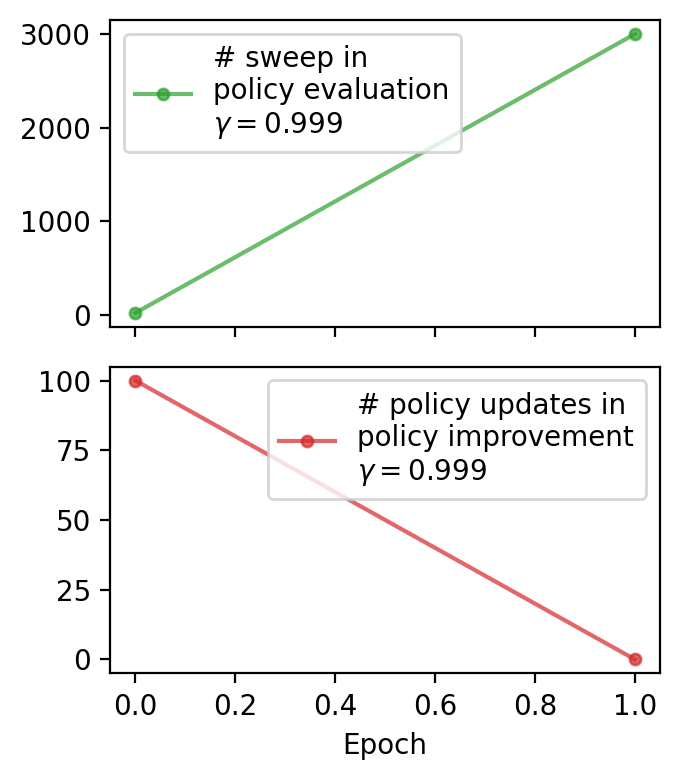

In [8]:
solver = PolicyIteration(mdp_model.reward_function, mdp_model.transition_model, gamma=0.999, sa_reward=sa_reward)
solver.train(total_epochs=100,eval_epochs=3000)
policy_save_path = 'dynamic_programming/ib_policy.pkl'

trained_policy = DPPolicy(policy_table=solver.policy, state_to_index=mdp_model.state_to_index,
                        index_to_action=mdp_model.index_to_actions)
trained_policy.save(policy_save_path)

In [9]:
print(solver.values)


[217945.29299504 218255.34909185 217927.22042848 218291.33589709
 217746.93281909 218191.33143624 218309.10446183 218339.73449233
 218454.03186097 218360.71899662 218400.29512792 217644.11052728
 217501.02341161 217410.20231248 217355.92690659 217688.89186231
 217666.90088261 217751.74696106 217776.63290386 217417.22438342
 217426.81290995 217999.90006396 218307.11923632 217702.89584696
 218296.27146821 218301.50100296 218372.77796485 218341.63631281
 218364.83009941 218316.59930298 218365.57264051 213378.41215181
 213465.70815993 213853.04740171 213286.90879219 212983.21270541
 218206.08977716 218198.28074506 218374.57749238 218204.63771278
 218376.29038729 218701.06622256 218423.60658096 218203.18722485
 218708.85009559 218322.57946107 218405.87818459 218394.61036887
 218369.70387878 218380.68143446 214145.55536431 216659.05139937
 216727.06497309 218465.07356886 216687.08018144 218720.26226266
 218243.87190894 217923.86366727 216876.97369106 218714.11252881
 218597.16212662 215465.3